# Machine Learning Foundations: Data Preparation

## Task 1: Data Loading and Initial Exploration

In [72]:
import pandas as pd

df = pd.read_excel('titanic3.xls')

print(df.head())
print(df.info())
print(df.describe())

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

From this output, we see that the dataset has 1,309 entries and 14 columns (features). Is this data enough? We cannot determine that yet without evaluating the planned models, goals, and performance metrics.

But using `.head()` to view the first 5 rows, I can visualize and inspect the structure of the dataset. This showed that we have a good mix of numerical and categorical variables:
- Numeric: `age`, `fare`
- Categorical but stored as numeric: `pclass` (1st, 2nd, 3rd class)
- Categorical stored as strings: `sex`, `embarked`, `home.dest`
These categorical columns will need encoding before training models. 

From this, we can also conclude that `cabin`, `boat`, `body` and `age` have missing values, meaning later on, we will need to handle them.

From `.describe()` we learn that:
- `age` has a wide range (min = 0, max = 80). Some values might be outliers.
- `fare` has a huge spread (max = 512). Some passengers paid very high fares, likely in 1st class.
- `pclass` is numeric but should be treated as categorical.
- `fare` has a high standard deviation meaning fares vary a lot.

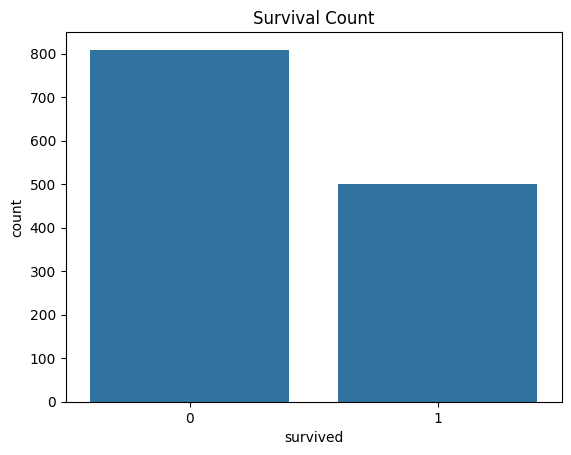

survived
0    0.618029
1    0.381971
Name: proportion, dtype: float64


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['survived'])
plt.title("Survival Count")
plt.show()

print(df['survived'].value_counts(normalize=True))  # Get class distribution %

Because our problem is to find out if a passanger will survive, I plotted these to the proportion of passangers that survived vs the ones that didn't. We got that 62% didnt and 38% did. This helps us see that there is a class imbalance. 

Why does this matter?
- If the model learns from imbalanced data, it might favor predicting non-survival since that is the majority class. 
- This could lead to bias, making it harder for the model to correctly identify survivors.

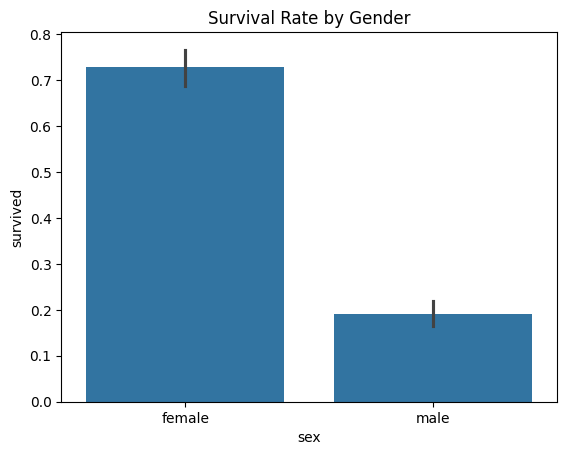

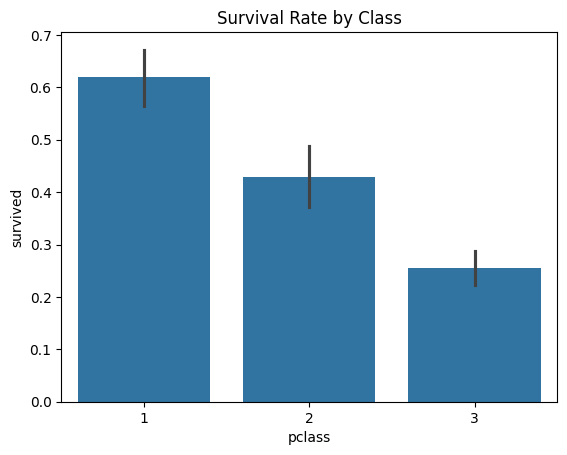

In [74]:
sns.barplot(x="sex", y="survived", data=df)
plt.title("Survival Rate by Gender")
plt.show()

sns.barplot(x="pclass", y="survived", data=df)
plt.title("Survival Rate by Class")
plt.show()

I also decide to plot survival rate by gender. This being because it is known that women were prioritized on the Titanic. Given the plot, we infact see that females have a survival rate above 70% and males have a much lower survival rate of below 20%. From this analysis I conluded that sex is a strong predictor of survival, meaning we should definitely keep it as a feature in our model. 

I also plotted survival rate by class. 1st class passengers had the highest survival rate (around 60%).2nd class passengers had a moderate survival rate (around 45%). 3rd class passengers had the lowest survival rate (around 25%). This tells us passenger class also played a major role in survival.

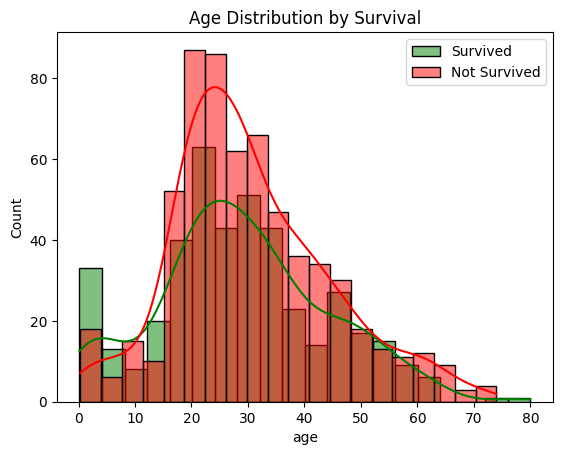

In [75]:
sns.histplot(df[df["survived"] == 1]["age"], bins=20, kde=True, label="Survived", color="green")
sns.histplot(df[df["survived"] == 0]["age"], bins=20, kde=True, label="Not Survived", color="red")
plt.legend()
plt.title("Age Distribution by Survival")
plt.show()

I decided to plot age by survival because I thought children might have been prioritized for lifeboats on the Titanic.

From the histogram, we can see that young children (ages 0 to 15 approximately) had a higher survival rate. This is shown by the green bars (survivors) being more prominent at young ages.

However, in the overall dataset, the red (non-survivors) and green distributions are fairly similar for adults (ages 20-40). This suggests that age alone may not be a strong predictor for survival in that range.

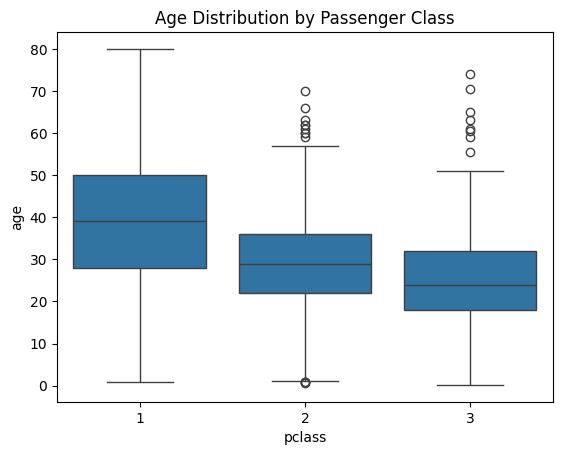

In [76]:
sns.boxplot(x="pclass", y="age", data=df)
plt.title("Age Distribution by Passenger Class")
plt.show()

To explore potential relationships between features, I plotted `pclass` vs. `age` to check if passenger class affects age distribution.

The plot shows that 1st class passengers tend to be older, while 3rd class passengers are generally younger. This suggests that `age` and `pclass` are correlated.

## Task 2: Managing Missing Values

First, we need to check which columns have missing values and how many are missing.

In [77]:
print(df.isnull().sum())  # Count missing values in each column

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


### Task 2.1: Dropping columns or fill missing values with a constant

In [78]:
df = df.drop(columns=['cabin', 'boat', 'body', 'home.dest', 'name', 'ticket']) # Drop columns with many missing values

df['age'].fillna(-999, inplace=True)  # Fill missing values with -999
df['fare'].fillna(-999, inplace=True)  
df['embarked'].fillna('Unknown', inplace=True)  # Fill missing values with 'Unknown'

/var/folders/6r/3wtbz049725_5tc7nk5smtj80000gp/T/ipykernel_46157/3840479481.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(-999, inplace=True)  # Fill missing values with -999
/var/folders/6r/3wtbz049725_5tc7nk5smtj80000gp/T/ipykernel_46157/3840479481.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

My strategy was to first drop all columns that have too many missing values. These being:
- `cabin` would've been a good feature to indicate luxury, but around 78% of the data was missing and therefore using it would've been unreliable. 
- `boat` and `body` are heavily related to survival so we drop them to remove the chance of data leakage. 
- `home.dest` because I thought it was irrelavant for predicting survival. 
- `name` and `ticket` I also dropped because I thought they were irrelevant for predicting survival and I later ran into some errors and realized that they needed to be encoded if I wanted to standardize the numerical variables.

On the other hand, I can't just drop the entire row for important features like `age`, `fare`, and `embarked`, so instead I filled them with constant placeholders. In the case of numerical variables like `age` and `fare` I used -999 and for embarked I used Unknown. I adopted this method because dropping missing values entirely might remove too much data and also to prevent errors when splitting the dataset. If we don’t handle them now, the dataset might break when we try to train a model. I initially filled the missing values with the mean/median immediately, but then realized we don’t want to do that before splitting because it would cause data leakage.

## Task 3: Data Splitting

I changed task 5 for task 3. Before we do anything like scaling, or encoding categorical variables, we first split the dataset into training, validation, and test sets. The reason for this is to avoid data leakage. 

In [79]:
from sklearn.model_selection import train_test_split
# Define features (X) and target variable (y)
X = df.drop(columns=['survived'])  # Drop target column
y = df['survived']  # Target variable

# First, split into training (70%) and temporary (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)  # Maintain class balance

# Then, split the temporary set into validation (50%) and test (50%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                stratify=y_temp)  # Maintain class balance

print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set distribution:\n", y_val.value_counts(normalize=True))
print("\nTest set distribution:\n", y_test.value_counts(normalize=True))

Training set distribution:
 survived
0    0.617904
1    0.382096
Name: proportion, dtype: float64

Validation set distribution:
 survived
0    0.617347
1    0.382653
Name: proportion, dtype: float64

Test set distribution:
 survived
0    0.619289
1    0.380711
Name: proportion, dtype: float64


For this task, I split the dataset into training, validation, and test sets to properly train and evaluate the model. We need to make sure that each split reflects the original class distribution (about 62% non-survivors and 38% survivors).

To do this, I used `train_test_split()` with stratification represented by `stratify=y`, so the proportion of survivors and non-survivors remains the same across all sets. This prevents the model from being biased toward one class.

First, I split the dataset into:

- 70% training data, which we will use to train the model.
- 30% temporary data,  which will be further split into validation and test sets.

I then took the 30% temporary data and split it 50/50 into:

- 15% validation data, which we will use to tune the model.
- 15% test data, which is used for the final evaluation.

### Task 2.2: Data imputation

In [80]:
# Fill missing 'age' using the median age based on 'pclass' (Only using training data)
X_train['age'] = X_train.groupby('pclass')['age'].transform(lambda x: x.fillna(x.median()))
X_val['age'] = X_val.groupby('pclass')['age'].transform(lambda x: x.fillna(X_train.groupby('pclass')['age'].median()))
X_test['age'] = X_test.groupby('pclass')['age'].transform(lambda x: x.fillna(X_train.groupby('pclass')['age'].median()))

# Fill missing 'fare' with median (Only using training data)
fare_median = X_train['fare'].median()
X_train['fare'].fillna(fare_median, inplace=True)
X_val['fare'].fillna(fare_median, inplace=True)
X_test['fare'].fillna(fare_median, inplace=True)

# Fill missing 'embarked' with mode (Only using training data)
embarked_mode = X_train['embarked'].mode()[0]
X_train['embarked'].fillna(embarked_mode, inplace=True)
X_val['embarked'].fillna(embarked_mode, inplace=True)
X_test['embarked'].fillna(embarked_mode, inplace=True)

# Check if all missing values are handled
print("Missing values in training set:\n", X_train.isnull().sum())
print("\nMissing values in validation set:\n", X_val.isnull().sum())
print("\nMissing values in test set:\n", X_test.isnull().sum())

Missing values in training set:
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

Missing values in validation set:
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

Missing values in test set:
 pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


/var/folders/6r/3wtbz049725_5tc7nk5smtj80000gp/T/ipykernel_46157/4275708409.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['fare'].fillna(fare_median, inplace=True)
/var/folders/6r/3wtbz049725_5tc7nk5smtj80000gp/T/ipykernel_46157/4275708409.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

Then to handle the now constant `age` values I used the imputation technique using the median `age` within each `pclass`. So my thought process behind this was that, as shown in the last plot of task 1, `pclass` is correlated with `age`; wealthier passengers tended to be older and poorer passengers tended to be younger. If I had used the overall median, it could have overestimated or underestimated ages depending on class. However if we fill in the values using the median age respective of their class we keep a more realistic age distribution. Also, its important to note that I chose the median instead of the mean to avoid the influence of outliers, given the large range of ages.

Since `fare ` is a numerical variable and only has 1 missing value, I thought it was reasonable to fill it with the median fare.

Since `embarked` is categorical variable and has only 2 missing values, I filled them with the most common embarkation point, in other words the mode. I thought this would be a reasonable guess given that `embarked` only has three possible values.

Finally, I printed the count of missing values again but this time of each set to check if all missing data was handled (it should print all zeros).

Since we use `val` and `test` sets are for unbiased and unseen data, we need to simulate how the model would handle real-world missing values. So, instead of calculating separate medians for `val` and `test`, we use the imputation values from `X_train`.

Why did I impute after splitting? If we imputed missing values before splitting the dataset, we would be using information from the entire dataset (including data from the test set) to fill in missing values. Imputing after splitting avoids this potential data leakage and simulates real world scenarios.

## Task 4: Encoding Categorical Variables

In [81]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
categorical_cols = ['sex', 'pclass', 'embarked']

# Initialize the encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category, return dense matrix

# Fit and transform the categorical variables
X = encoder.fit_transform(df[categorical_cols])

# Get feature names
feature_names = encoder.get_feature_names_out(categorical_cols)

# Convert the transformed data into a DataFrame
encoded_df = pd.DataFrame(X, columns=feature_names)

# Display the encoded DataFrame
display(encoded_df)

,sex_male,pclass_2,pclass_3,embarked_Q,embarked_S,embarked_Unknown
0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
1304,0.0,0.0,1.0,0.0,0.0,0.0
1305,0.0,0.0,1.0,0.0,0.0,0.0
1306,1.0,0.0,1.0,0.0,0.0,0.0
1307,1.0,0.0,1.0,0.0,0.0,0.0


Since machine learning models can’t work with categorical data, I needed to convert categorical variables into numerical form. For this, I used One-Hot Encoding, which transforms categories into multiple binary (0/1) columns.

From the dataset, the categorical features that need encoding are:

- `sex` → Male/Female
- `pclass` → 1st, 2nd, 3rd class
- `embarked` → S, C, Q

By default, One-Hot Encoding creates separate binary columns for each category. However, I decided to use  `drop='first'`, which removes one category per feature. I did this for redundancy purposes. For example, if the binary column sex_male is 0 it is implied that the passenger is female. It also prevents multicollinearity, which can confuse our Logistic Regression model.  

I also set `sparse=False`. Why? Because I wanted a normal NumPy array to make it easier to convert to a Pandas DataFrame.

After encoding, my dataset changed:

- `pclass_1` was dropped, and only `pclass_2` and `pclass_3` remain.
- `embarked_C` was dropped, and only `embarked_Q` and `embarked_S` remain.
- `sex_male` is the only column for `sex`, meaning 0 = female, 1 = male.

## Task 5: Feature Scaling

For this task, I started by identifying the numerical variables in the dataset:
- `age`
- `fare`

At first, there’s no way to know which method is better for our dataset, so I applied both:

- Standardization (`StandardScaler`)
- Normalization (`MinMaxScaler`)

After applying both methods, I plotted the distributions for `age` and `fare` to compare the results.

In [82]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler_standard = StandardScaler()

# Fit and transform numerical variables
X_standard = scaler_standard.fit_transform(df[['age', 'fare']])

# Convert to DataFrame
feature_names = ['age_scaled', 'fare_scaled']
standardized_df = pd.DataFrame(X_standard, columns=feature_names)

# Display results
display(standardized_df.head())

,age_scaled,fare_scaled
0,0.499051,3.027843
1,0.430964,2.015560
2,0.433590,2.015560
3,0.501476,2.015560
4,0.489353,2.015560


In [83]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler_minmax = MinMaxScaler()

# Fit and transform numerical variables
X_minmax = scaler_minmax.fit_transform(df[['age', 'fare']])

# Convert to DataFrame
feature_names = ['age_minmax', 'fare_minmax']
normalized_df = pd.DataFrame(X_minmax, columns=feature_names)

# Display results
display(normalized_df.head())

,age_minmax,fare_minmax
0,0.952734,0.800843
1,0.926707,0.761284
2,0.927711,0.761284
3,0.953661,0.761284
4,0.949027,0.761284


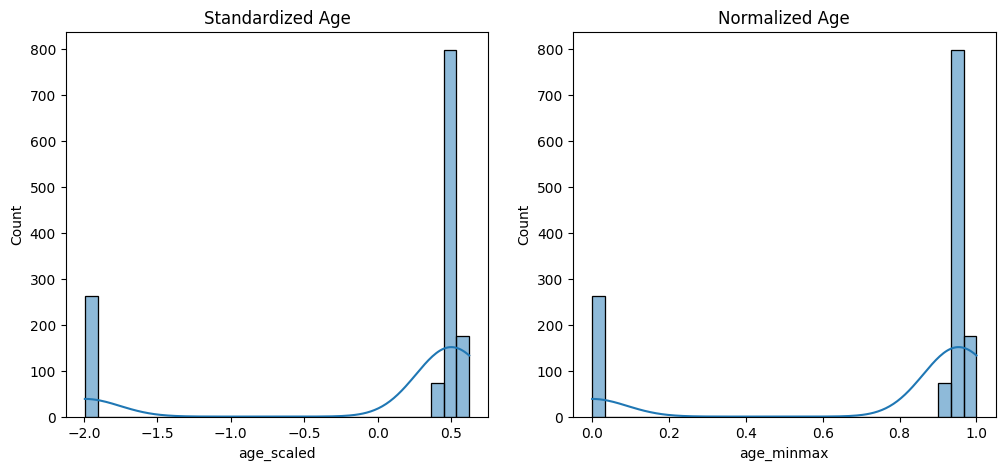

In [84]:
# Plot standardized vs normalized `age`
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(standardized_df['age_scaled'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Standardized Age")

sns.histplot(normalized_df['age_minmax'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Normalized Age")

plt.show()

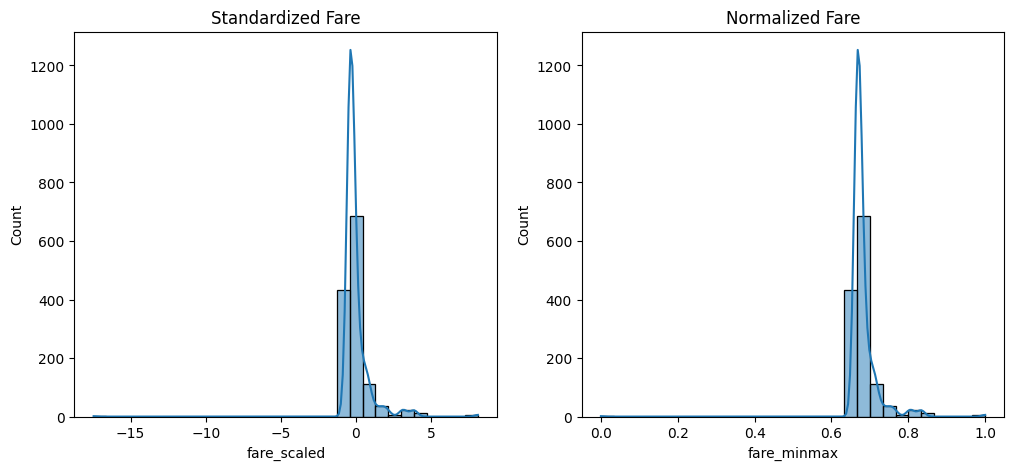

In [85]:
# Plot standardized vs normalized `fare`
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(standardized_df['fare_scaled'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Standardized Fare")

sns.histplot(normalized_df['fare_minmax'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Normalized Fare")

plt.show()

### Choosing Standardization

Looking at the plots, I noticed that `age` is roughly normally distributed, meaning it follows a weak bell curve (even though it’s not perfect). A common rule of thumb is that standardization works best for normally distributed data, so that already makes it a strong candidate.

But the real reason I chose `StandardScaler` is because of `fare`.

- `fare` has extreme values, with a max value of around 512.
- `MinMaxScaler` is sensitive to outliers because it squishes everything into [0,1]. Extreme values can compress the rest of the data.
- `StandardScaler` handles outliers better because it keeps the data centered around 0. This means that even if there are extreme values the model won’t be too sensitive to them.

Since I plan to use Logistic Regression, standardization is the better choice because it assumes normally distributed data and performs best when all features are centered around 0 with equal variance.

Scaling is important because machine learning models, especially Logistic Regression, work best when features are on similar scales. Without scaling, features like `fare` for example, would dominate smaller values like `age`, affecting how the model learns. 

To conclude, the difference between these two techniques is that standardization transforms the data to have a mean of 0 and a standard deviation of 1, preserving the original distribution but adjusting the scale. On the other hand, normalization rescales all values between 0 and 1, making everything relative to the minimum and maximum values. The key difference is that standardization handles outliers better because it doesn’t compress extreme values, while normalization is more sensitive to outliers. 

## Task 6: Addressing Class Imbalance

So for this task I discarded undersampling because the dataset isn't very large so every bit of data is important to make our model better, in other words removing data is not ideal. 

Instead, I chose oversampling, more specifically, SMOTE. 

In [86]:
print(X_train.dtypes)

pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object


In [87]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Define SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Before SMOTE:", np.bincount(y_train))  # Original class distribution
print("After SMOTE:", np.bincount(y_train_resampled))  # Balanced class distribution

ValueError: could not convert string to float: 'male'